```
Copyright 2019 Augusto Cunha and Axelle Pochet

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Augusto Cunha, Axelle Pochet"
__email__ = "acunha@tecgraf.puc-rio.br, axelle@tecgraf.puc-rio.br"
__credits__ = ["Augusto Cunha", "Axelle Pochet", "Helio Lopes", "Marcelo Gattass"]
```

# SFD-CNN-TL: Classify and view Feature Map

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import cv2
import keract
import pandas as pd
import numpy as np
import matplotlib.ticker as tcr
import matplotlib.pyplot as plt
import matplotlib.image as im
import skimage.morphology as morphology
import classifier
import imageio
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
from sklearn.feature_extraction import image
from skimage.filters import gaussian
from skimage import measure
from PIL import Image, ImageDraw
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# Enable interactive plots
#%matplotlib notebook

## Define a seismic name

In [2]:
seismic_name = "gsb"

## Open synthetic slice and create patches

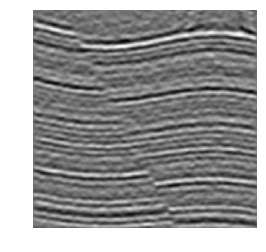

In [3]:
section =np.genfromtxt("SyntheticSection_457.csv", delimiter=' ')
section = section.T
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(section, cmap="gray", aspect='auto')

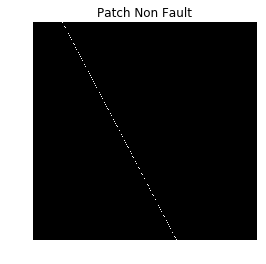

In [4]:
mask_img = cv2.imread("SyntheticSection_457_mask.png")
mask_img = mask_img[:,:,1]
mask_img = mask_img/255

plt.figure(figsize=(4,4))
plt.title('Patch Non Fault')
plt.axis('off')
plt.imshow(mask_img, cmap="gray", aspect='auto')

In [5]:
width = section.shape[1]
height = section.shape[0]
mask_size =45

patches_fault = []
patches_non_fault = []

patches_img = image.extract_patches_2d(section, (mask_size, mask_size))
patches_mask = image.extract_patches_2d(mask_img, (mask_size, mask_size))

for i in range(0, len(patches_mask)):
    if (patches_mask[i] == 0).sum() == patches_mask[i].size:
        patch = patches_img[i]
        patches_non_fault.append(patch)
    elif patches_mask[i][int(mask_size/2),int(mask_size/2)]==1:
        patch = patches_img[i]
        patches_fault.append(patch)

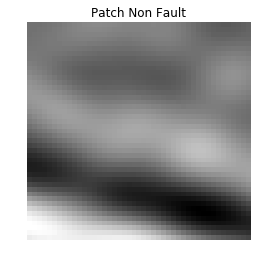

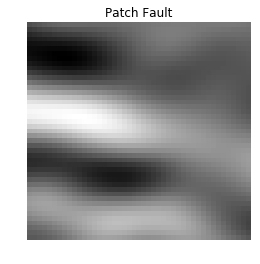

In [6]:
plt.figure(figsize=(4,4))
plt.title('Patch Non Fault')
plt.axis('off')
plt.imshow(patches_non_fault[20], cmap="gray", aspect='auto')

plt.figure(figsize=(4,4))
plt.title('Patch Fault')
plt.axis('off')
plt.imshow(patches_fault[40], cmap="gray", aspect='auto')

## Load VGG model and classify

In [47]:
def create_VGG():
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    vgg_model = model_from_json(loadedModelJson)
    vgg_model.load_weights(modelWeightsPath)
    vgg_model.summary()
     # Compile
    vgg_model.compile( loss='binary_crossentropy', optimizer= 'sgd', metrics=['accuracy'] )
    
    return vgg_model

In [48]:
model = create_VGG()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 43, 20)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 20)        3620      
_________________________________________________________________
activation_1 (Activation)    (None, 41, 41, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 20)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 50)        9050      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 50)        22550     
__________

In [ ]:
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(patches_fault[60].reshape(1,45,45)[0], cmap="gray", aspect='auto')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(tcr.NullLocator())
plt.gca().yaxis.set_major_locator(tcr.NullLocator())
plt.savefig('patch.png', bbox_inches='tight',pad_inches=0)

In [68]:
classesPredictionList = model.predict_classes(patches_fault[60].reshape(1,45,45,1), verbose=0) # 0 or 1
print(classesPredictionList)

[1]


In [69]:
activations = keract.get_activations(model, patches_fault[60].reshape(1,45,45,1))

activation_4_1/Relu:0 (1, 8, 8, 50) 


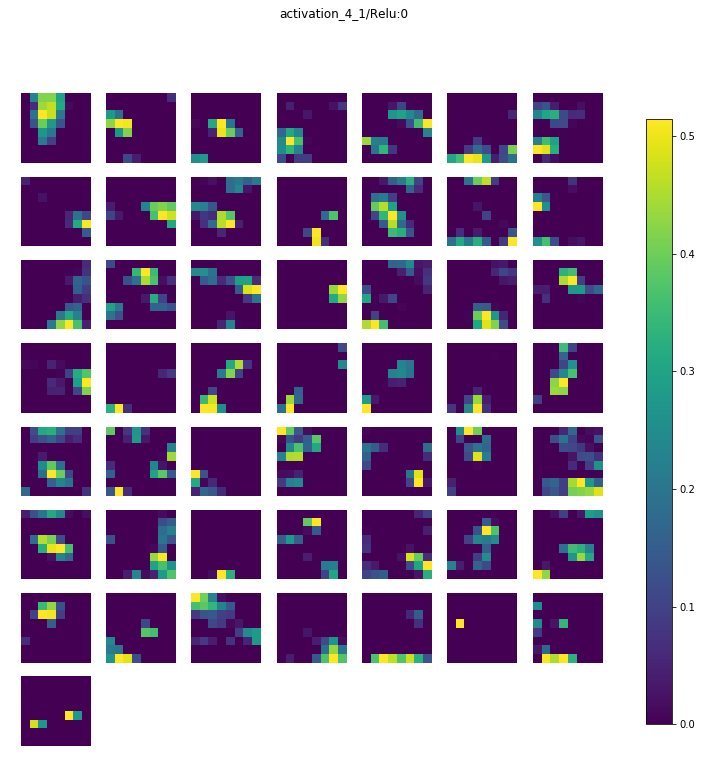

dense_1_1/BiasAdd:0 (1, 16) -> Skipped. 2D Activations.
max_pooling2d_1_1/MaxPool:0 (1, 20, 20, 20) 


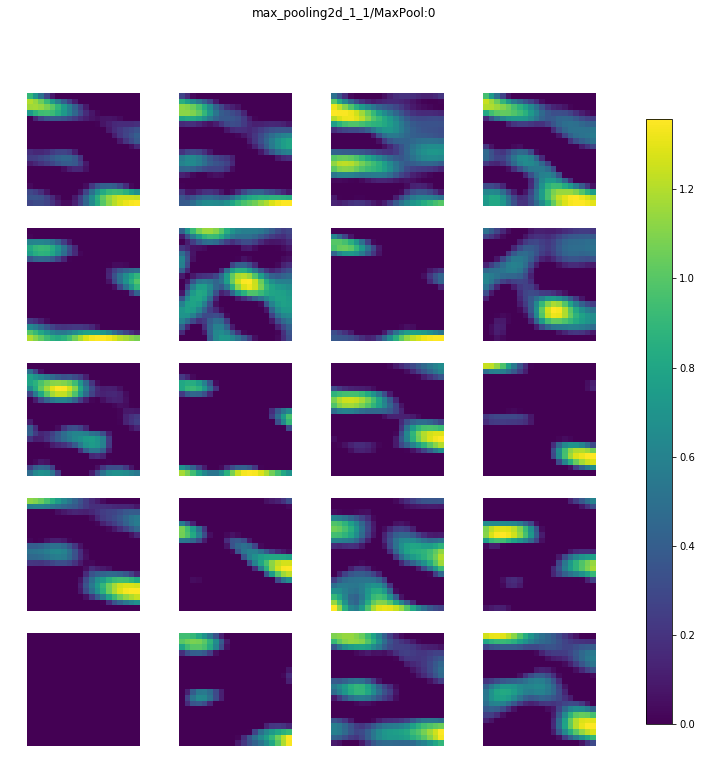

activation_6_1/Relu:0 (1, 32) -> Skipped. 2D Activations.
activation_5_1/Relu:0 (1, 16) -> Skipped. 2D Activations.
dense_3_1/BiasAdd:0 (1, 2) -> Skipped. 2D Activations.
conv2d_3_1/BiasAdd:0 (1, 18, 18, 50) 


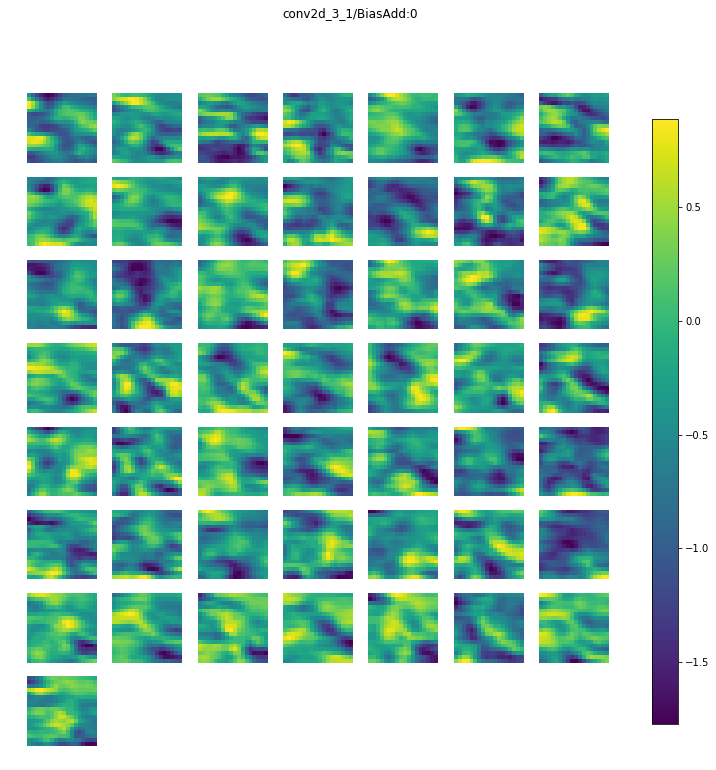

conv2d_2_1/BiasAdd:0 (1, 41, 41, 20) 


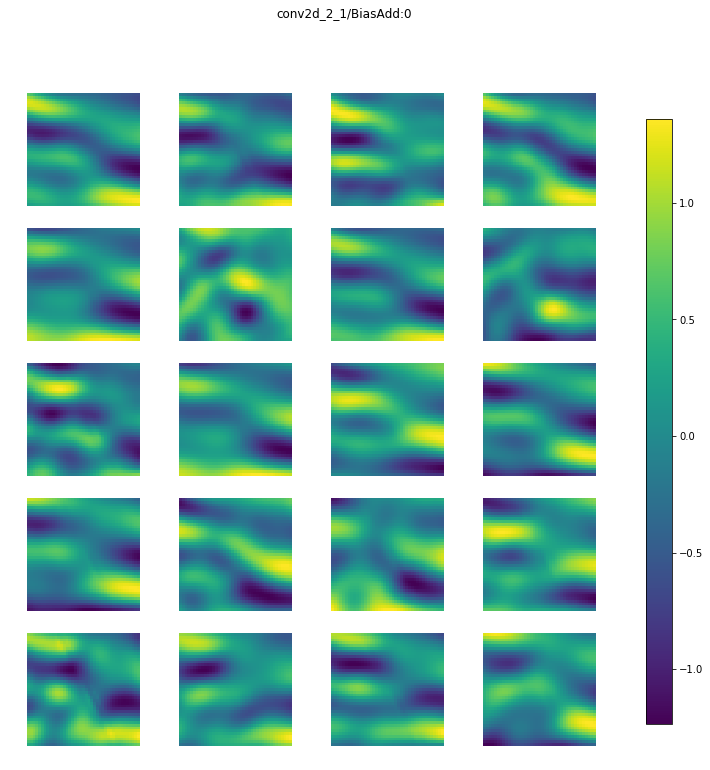

max_pooling2d_2_1/MaxPool:0 (1, 8, 8, 50) 


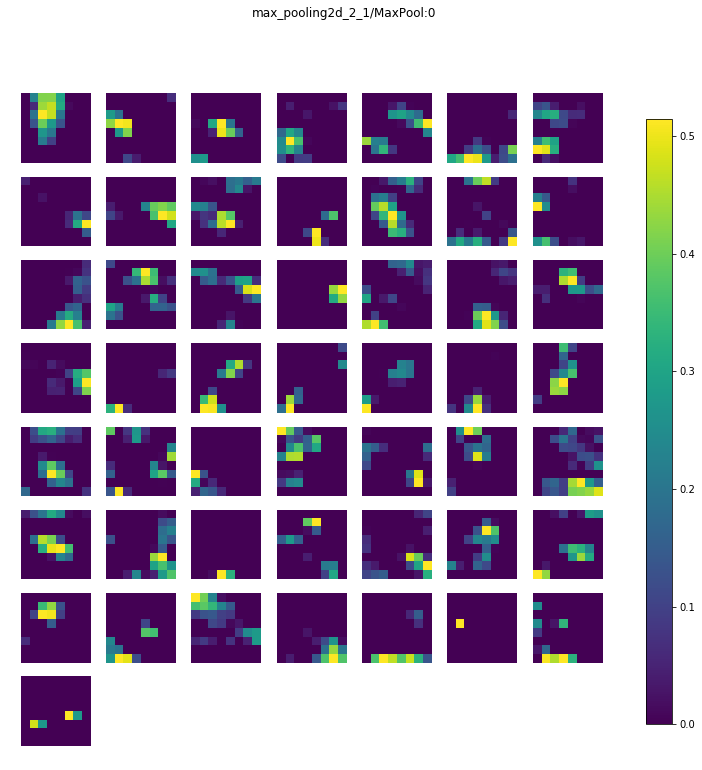

dropout_1_1/cond/Merge:0 (1, 16) -> Skipped. 2D Activations.
activation_3_1/Relu:0 (1, 16, 16, 50) 


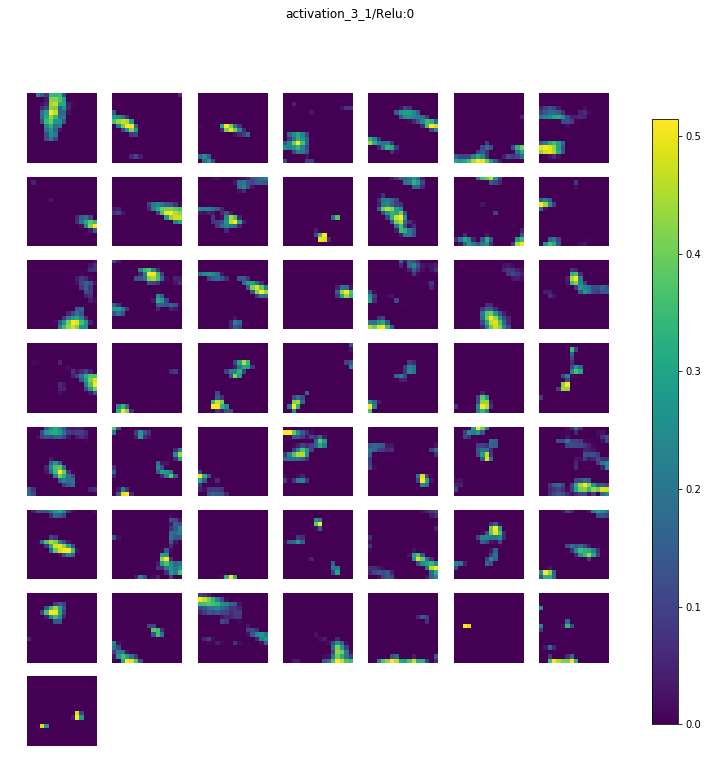

activation_2_1/Relu:0 (1, 20, 20, 20) 


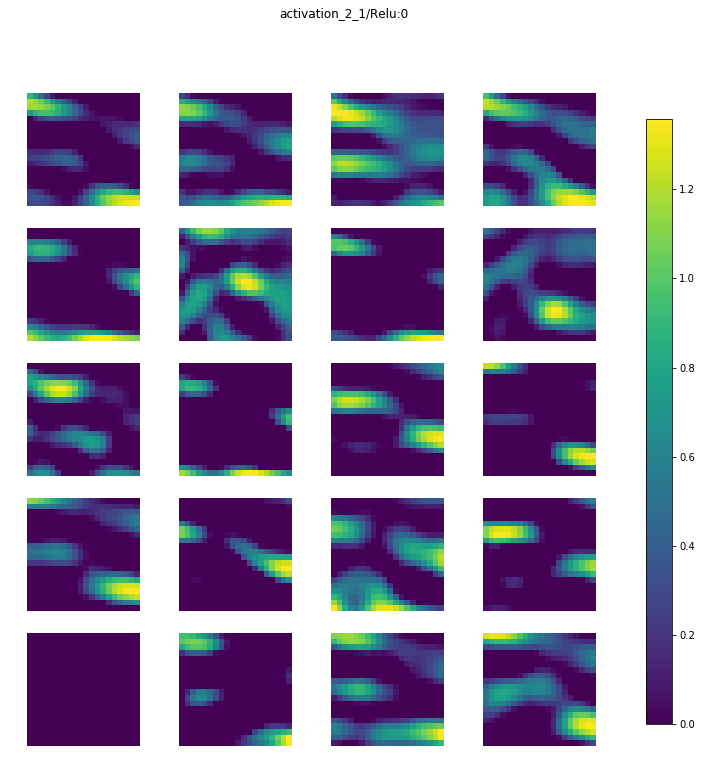

activation_7_1/Softmax:0 (1, 2) -> Skipped. 2D Activations.
conv2d_4_1/BiasAdd:0 (1, 16, 16, 50) 


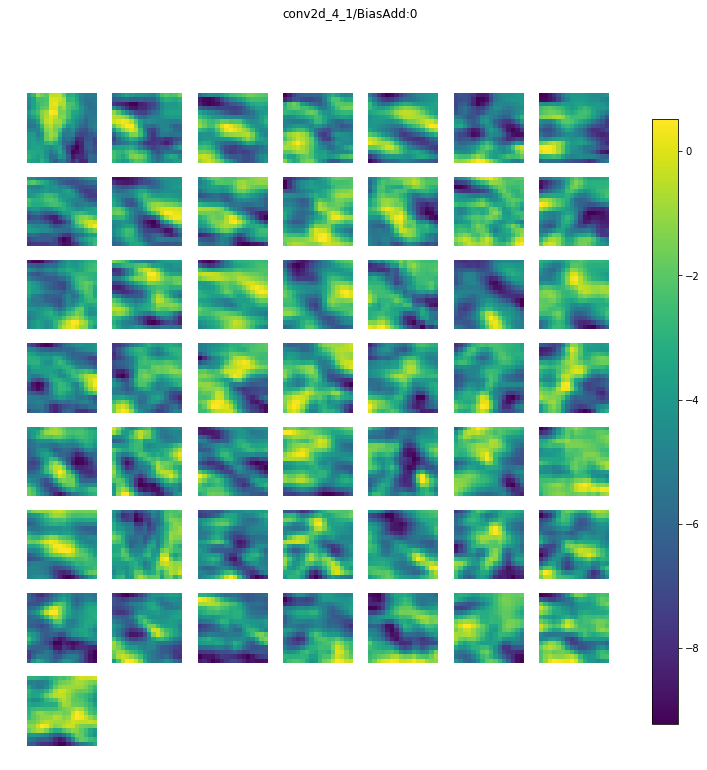

flatten_1_1/Reshape:0 (1, 3200) -> Skipped. 2D Activations.
activation_1_1/Relu:0 (1, 41, 41, 20) 


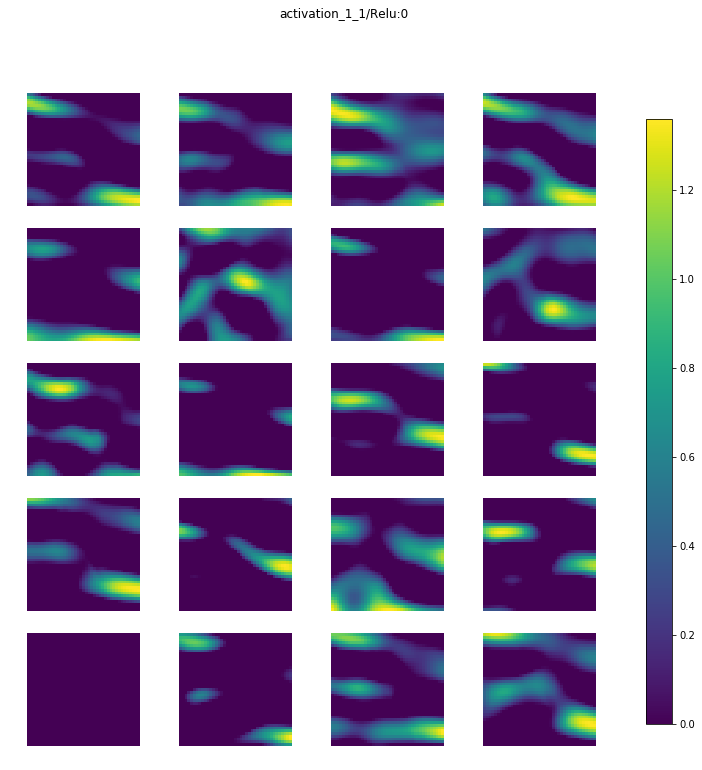

dense_2_1/BiasAdd:0 (1, 32) -> Skipped. 2D Activations.
conv2d_1_1/BiasAdd:0 (1, 43, 43, 20) 


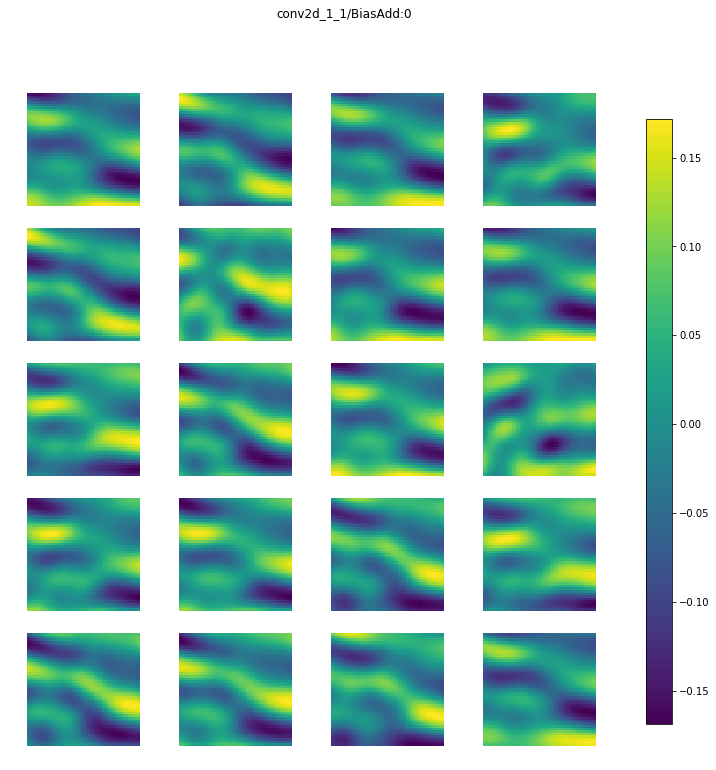

In [116]:
keract.display_activations(activations, save=False)

activation_4_1/Relu:0 (1, 8, 8, 50) 


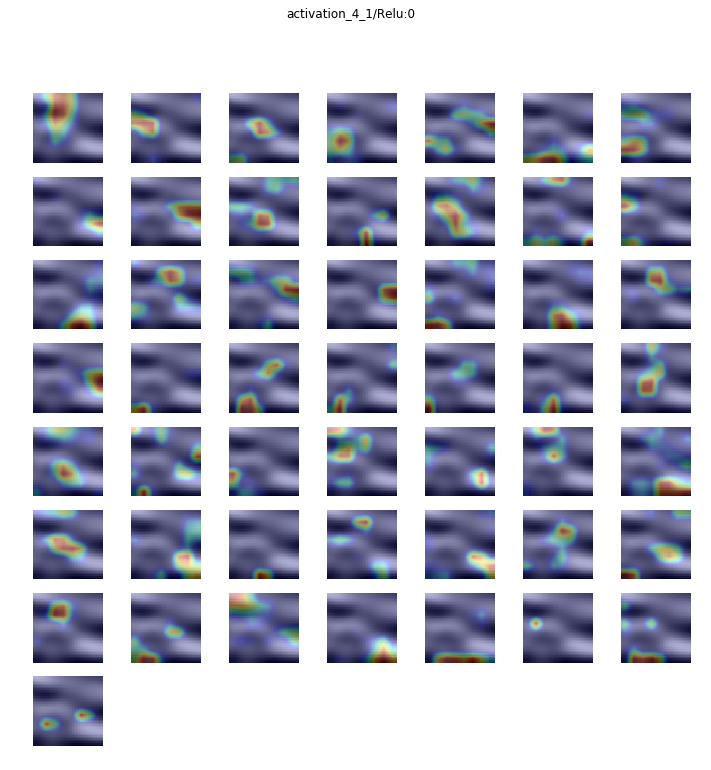

dense_1_1/BiasAdd:0 (1, 16) -> Skipped. 2D Activations.
max_pooling2d_1_1/MaxPool:0 (1, 20, 20, 20) 


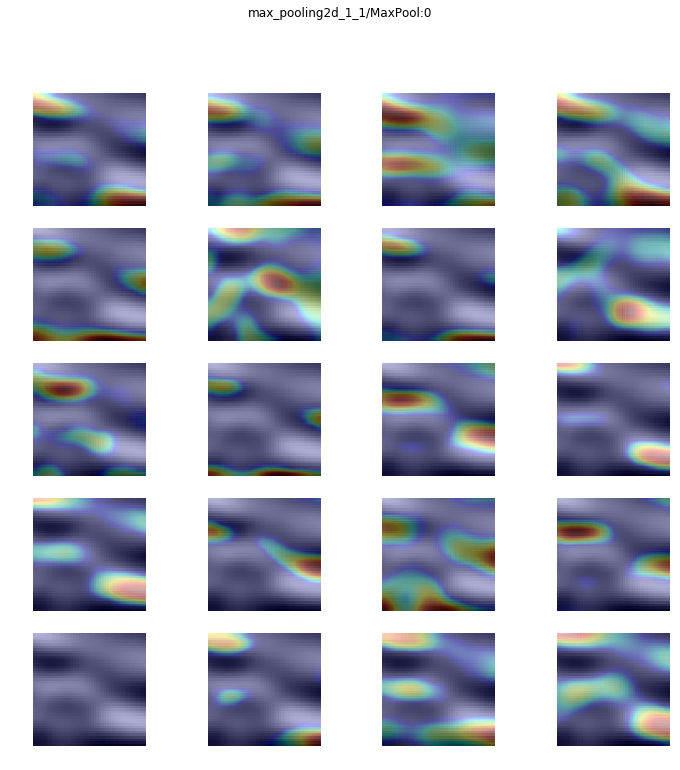

activation_6_1/Relu:0 (1, 32) -> Skipped. 2D Activations.
activation_5_1/Relu:0 (1, 16) -> Skipped. 2D Activations.
dense_3_1/BiasAdd:0 (1, 2) -> Skipped. 2D Activations.
conv2d_3_1/BiasAdd:0 (1, 18, 18, 50) 


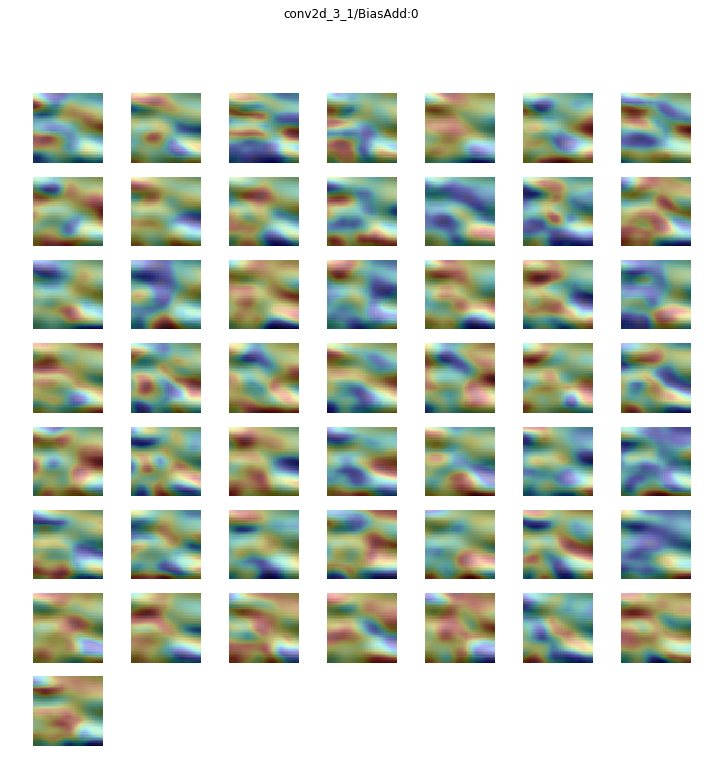

conv2d_2_1/BiasAdd:0 (1, 41, 41, 20) 


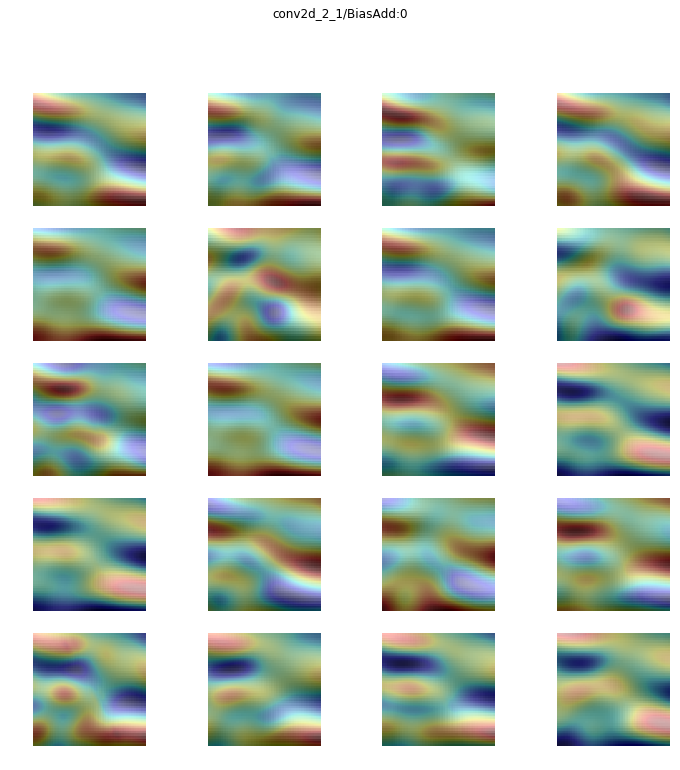

max_pooling2d_2_1/MaxPool:0 (1, 8, 8, 50) 


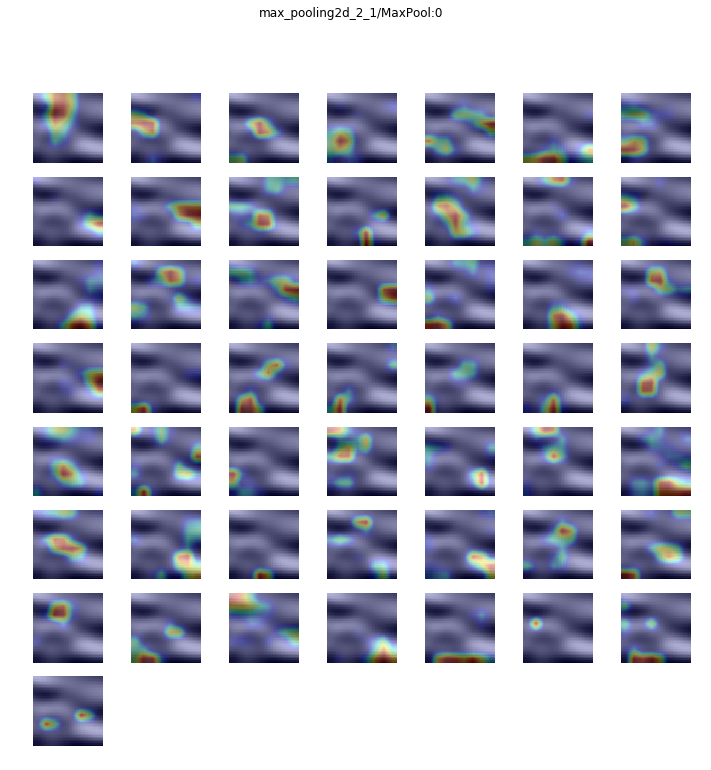

dropout_1_1/cond/Merge:0 (1, 16) -> Skipped. 2D Activations.
activation_3_1/Relu:0 (1, 16, 16, 50) 


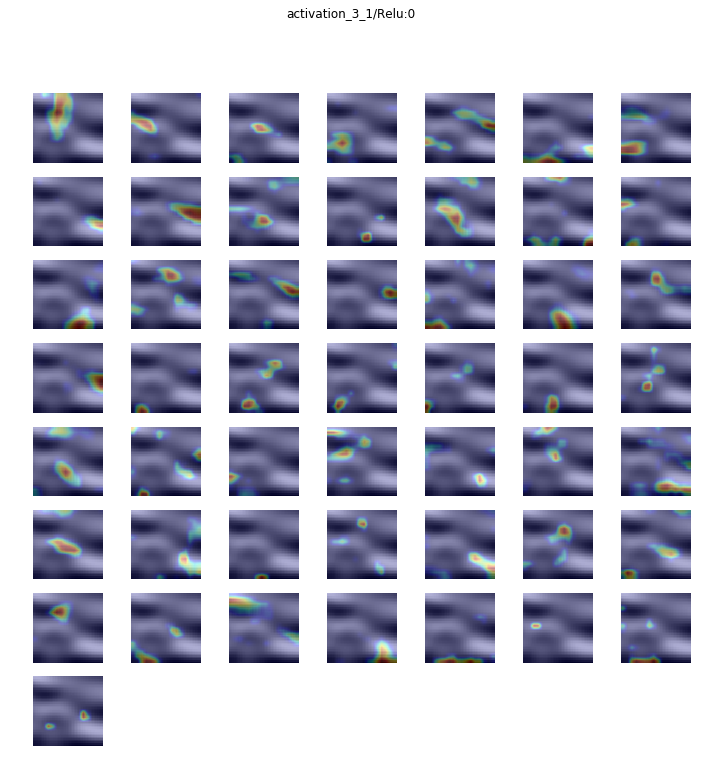

activation_2_1/Relu:0 (1, 20, 20, 20) 


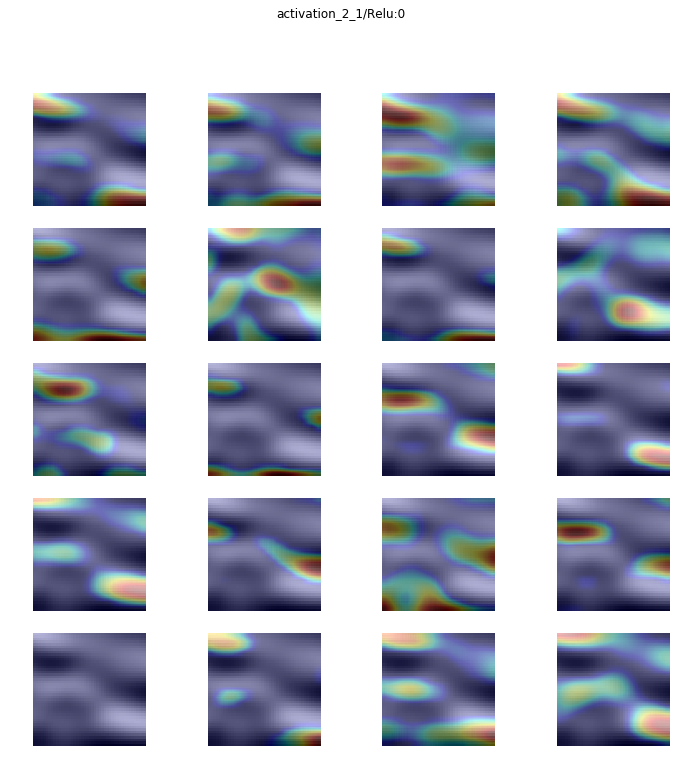

activation_7_1/Softmax:0 (1, 2) -> Skipped. 2D Activations.
conv2d_4_1/BiasAdd:0 (1, 16, 16, 50) 


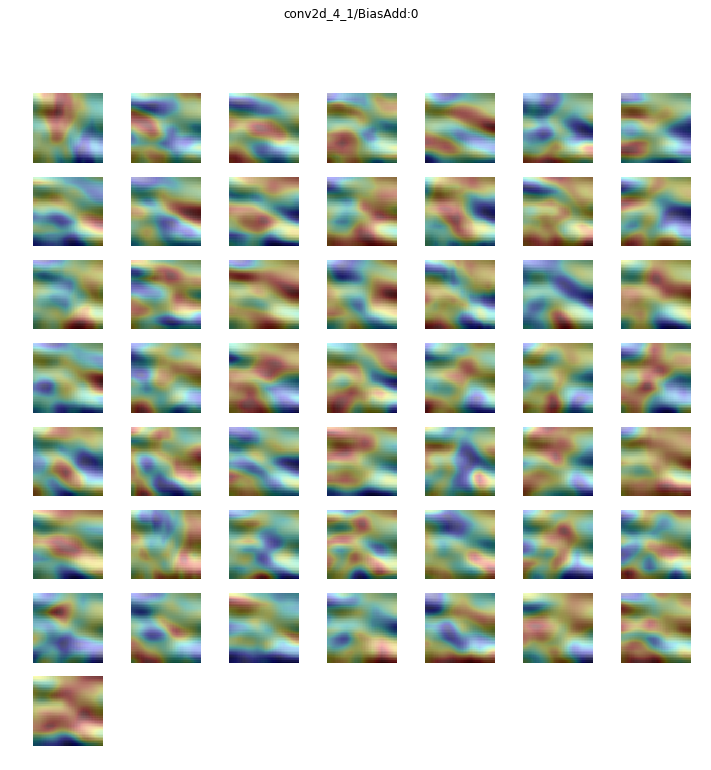

flatten_1_1/Reshape:0 (1, 3200) -> Skipped. 2D Activations.
activation_1_1/Relu:0 (1, 41, 41, 20) 


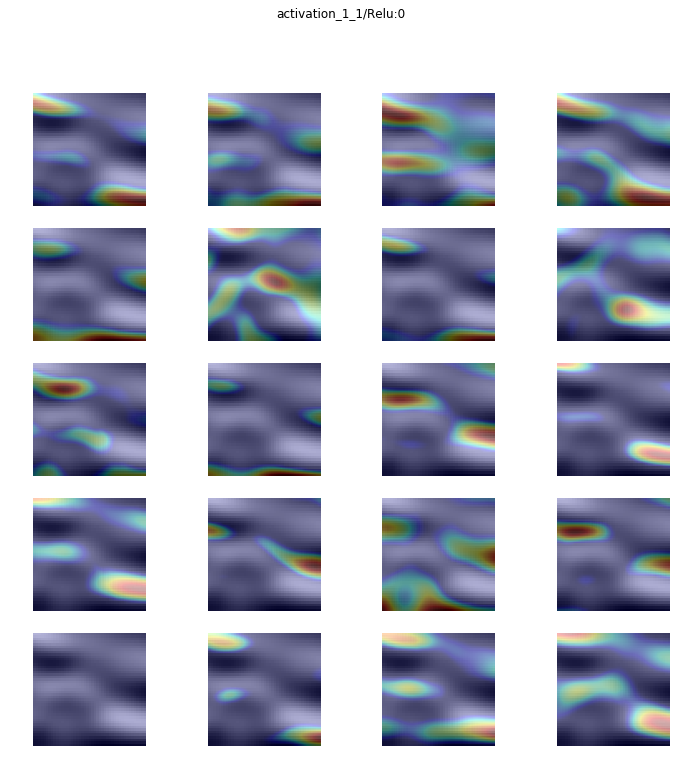

dense_2_1/BiasAdd:0 (1, 32) -> Skipped. 2D Activations.
conv2d_1_1/BiasAdd:0 (1, 43, 43, 20) 


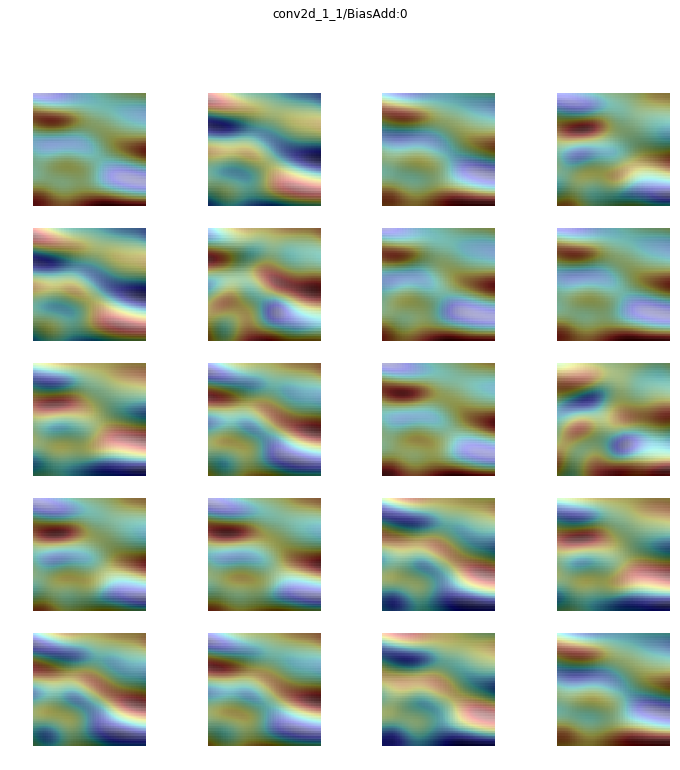

In [117]:
keract.display_heatmaps(activations, cv2.imread("patch.png")[2:290,2:290,:], save=False)